# Homework

You need to train the model and get score as big as you can

Dataset: https://disk.yandex.ru/d/gcGKZ_KsXZN4VA

### Prepare part

In [ ]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tqdm.notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import urllib

from IPython.display import clear_output

%matplotlib inline

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/gcGKZ_KsXZN4VA'
final_url = base_url + urllib.parse. urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O data.tar.gz "{download_url}"
!tar -xf data.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.appl

In [ ]:
import torchaudio.transforms as T

In [ ]:
class AugmentationPipeline:
    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate
        self.augmentations = [
            lambda x: add_noise(x, noise_level=0.005),
            lambda x: time_shift(x, shift_limit=0.1),
            lambda x: T.FrequencyMasking(freq_mask_param=10)(x),
            lambda x: T.TimeMasking(time_mask_param=20)(x),
            lambda x: pitch_shift(x, self.sample_rate, n_steps=random.randint(-2, 2)),
            lambda x: adjust_volume(x, gain_db=random.uniform(-2, 2))
        ]

    def apply(self, waveform):
        for augment in self.augmentations:
            if random.random() < 0.20:  # 50% chance for each augmentation
                waveform = augment(waveform)
        return waveform

# Define augmentation functions
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise

def time_shift(waveform, shift_limit=0.1):
    shift = int(waveform.size(1) * shift_limit * torch.rand(1).item())
    return torch.roll(waveform, shifts=shift, dims=1)

def pitch_shift(waveform, sample_rate, n_steps=2):
    pitch_transform = T.PitchShift(sample_rate, n_steps=n_steps)
    return pitch_transform(waveform)

def adjust_volume(waveform, gain_db=5):
    gain = T.Vol(gain_db)
    return gain(waveform)

In [ ]:
DEVICE = device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'ml_trains_data'
LOADER_WORKERS = 0

In [ ]:
class Dataset(torch_data.Dataset):
    def __init__(self, split_part: str, datadir: str, feats: nn.Module, read_labels=True, train=True):
        super().__init__()
        data = pd.read_csv(os.path.join(datadir, f'{split_part}.tsv'), sep='\t')
        if read_labels:
            labels = {key: idx for idx, key in enumerate(sorted(set(data.label.values)))}
            self._idx_to_label = {idx: key for idx, key in enumerate(sorted(set(data.label.values)))}
            self._classes = len(labels)
        self._feats = feats
        self._ytids = []
        self._pathes = []
        self._labels = []
        self.augment = AugmentationPipeline() if train else None
        for _, row in data.iterrows():
            path = os.path.join(datadir, 'clips', f'{row.YTID}.flac')
            if os.path.exists(path):
                self._ytids.append(row.YTID)
                self._pathes.append(path)
                self._labels.append(labels[row.label] if read_labels else 0)

    def __getitem__(self, index):
        try:
            waveform, sample_rate = torchaudio.load(self._pathes[index])
        except Exception as err:
            logging.error("Can't read file %s", self._pathes[index])
            raise err
        assert sample_rate == 16000
        assert waveform.shape[0] == 1
        feats = self._feats(waveform)[0]
        return (feats, self._labels[index])

    def __len__(self) -> int:
        return len(self._pathes)

    def classes(self) -> int:
        return self._classes


def collate_fn(batch):
    max_length = max(item[0].shape[1] for item in batch)
    X = torch.zeros((len(batch), batch[0][0].shape[0], max_length))
    for idx, item in enumerate(batch):
        X[idx, :, :item[0].shape[1]] = item[0]
    targets = torch.tensor([item[1] for item in batch], dtype=torch.long).reshape(len(batch), 1)
    return (X, targets)

### Feats part

In [ ]:
pd.read_csv('/content/ml_trains_data/train.tsv', sep='\t').label.value_counts()

,count
label,
Speech,1600
Music,1528
Vehicle,1108
Animal,1042
Siren,984
Bird,932
Water,899
Engine,879
Tools,874


In [ ]:
# FBANK 40 by default, but you can choose something else /content/ml_trains_data/train.tsv
FEATS = 40
transform_mfcc = torchaudio.transforms.MFCC(
    n_mfcc=FEATS,
    melkwargs =
    {
        'n_fft': 512,
        'hop_length': 256,
        'win_length': 512,
        'n_mels': 40,
        'f_min': 50,
        'f_max': 8000
    }
)

#transform_mfcc = torchaudio.transforms.MFCC(n_mfcc=FEATS)
trainset = Dataset('train', '/content/ml_trains_data', transform_mfcc)
testset = Dataset('eval', '/content/ml_trains_data', feats=transform_mfcc, read_labels=False)
N_CLASSES = trainset.classes()
assert N_CLASSES == 30

### Eval part

Write balanced accuracy:
$$BAcc = \frac{1}{classes}\sum_{c = 1}^{classes} \frac{\sum_i^n I(y_i = p_i = c)}{\sum_i^n I(y_i = c)}$$

Where:
- $y_i$ -- target class for $i$ element
- $p_i$ -- predicted class for $i$ element

In [ ]:
# Get list of pairs (target_class, predicted_class)
def balanced_accuracy(items: list[tuple[int, int]], classes=N_CLASSES) -> float:

    corr_cnt = 0
    for i in range(classes):
      for pair in items:
        print('class, pair', i,)
        if pair[0] == pair[1] and pair[0] == i:
            if pair[0] == i:
                print('Correct!')
                corr_cnt += 1
            else:
                continue
        else:
            continue

    b_acc = corr_cnt / classes

    return b_acc

In [ ]:
def balanced_accuracy(items: list[tuple[int, int]], classes: int) -> float:
    """
    Calculate the Balanced Accuracy (BAcc).

    Parameters:
    - items: list of tuples, where each tuple contains (true_class, predicted_class).
    - classes: int, number of classes.

    Returns:
    - float, balanced accuracy.
    """
    # Initialize a list to store accuracies for each class
    class_accuracies = []

    for c in range(classes):
        # Filter items for the current class
        true_c = [item for item in items if item[0] == c]
        # Count total and correct predictions for this class
        total_c = len(true_c)
        correct_c = sum(1 for item in true_c if item[1] == c)
        # Handle cases where a class has no instances
        if total_c == 0:
            class_accuracy = 1.0  # Assume perfect accuracy if no instances exist
        else:
            class_accuracy = correct_c / total_c
        class_accuracies.append(class_accuracy)
    # Compute the balanced accuracy
    balanced_acc = sum(class_accuracies) / classes

    return balanced_acc

In [ ]:
balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2)

1.0

In [ ]:
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 1)], 2), 1.0)
assert np.isclose(balanced_accuracy([(0, 1), (1, 0)], 2), 0.0)
assert np.isclose(balanced_accuracy([(0, 0), (0, 0), (1, 0)], 2), 0.5)
assert np.isclose(balanced_accuracy([(0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (0, 1)], 2), 0.625)
assert np.isclose(balanced_accuracy([(1, 1), (0, 1), (2, 2)], 3), 0.66666666666666)

### Train part
Train some model with as big balanced accuracy as you can

You can train any model you want. The only limitation is that it must be trained from scratch on the data provided in the task. For example you can choose model from:
- DNN
- CNN 1d
- CNN 2d
- Transformer
- RNN
- mixes of given models

Hints:
- No need to train large models for this task. 10 million parameters is more than you need.
- Watch to overfitting, try to add Augmentation, Dropout, BatchNorm, L1/L2-Regulatization or something else.
- Use poolings or strides to reduce time-dimenstion. It is better to reduce the dimension gradually rather than at the end.
- Try different features (mel-spec, log-mel-spec, mfcc)

In [ ]:
def stage(
    model: nn.Module,
    data: torch_data.Dataset,
    opt: optim.Optimizer,
    batch_size: int = 256,
    train: bool = True
):
    loader = torch_data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=LOADER_WORKERS,
        collate_fn=collate_fn
    )
    if train:
        model.train()
    else:
        model.eval()
    loss_sum, batches = 0.0, 0
    pred_pairs = []
    for X, Y in tqdm.tqdm(loader):
        pred = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(pred.squeeze(), Y.squeeze().to(DEVICE))
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        loss_sum += loss.item()
        batches += 1
        with torch.no_grad():
            pred_pairs.extend(zip(
                Y.data.numpy().reshape(-1),
                torch.argmax(pred, dim=1).cpu().data.numpy().reshape(-1)
            ))
    return loss_sum / batches, balanced_accuracy(pred_pairs, 30)


def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
):
    train_data, val_data = torch.utils.data.random_split(trainset, (0.9, 0.1), generator=torch.Generator().manual_seed(42))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc = stage(model, train_data, opt, batch_size=batch_size)
        val_loss, val_acc = stage(model, val_data, opt, batch_size=batch_size, train=False)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis[0].plot(np.arange(1, epoch + 2), val_losses, label='val')
        axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_loss}. Train accuracy {train_acc}.')
        print(f'Test loss {val_loss}. Test accuracy {val_acc}')

In [ ]:
class ImprovedModel(nn.Module):
    def __init__(self, in_dim=FEATS, out_dim=N_CLASSES):
        """
        Enhanced Conv1D model for music genre classification.

        Parameters:
        - in_dim: int, number of input features (e.g., Mel spectrogram dimensions).
        - out_dim: int, number of output classes (music genres).
        """
        super().__init__()

        # First Block
        self.conv1 = nn.Conv1d(in_dim, 64, kernel_size=3, stride=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.1)

        # First_2 Block
        self.conv1_1 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
        self.bn1_1 = nn.BatchNorm1d(64)
        self.max_pool_1 = nn.AdapMaxPool1d(kernel_size=3, stride=3)
        self.dropout1 = nn.Dropout(0.1)

        # Second Block
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.max_pool_2 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.dropout2 = nn.Dropout(0.2)

        # Third Block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.max_pool_3 = nn.MaxPool1d(kernel_size=3, stride=3)
        self.dropout3 = nn.Dropout(0.2)

        # Third_1 Block
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.2)

        # Global Pooling: Average + Max pooling combined
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, out_dim)  # 256 * 2 because we concatenate avg and max pooling

    def forward(self, X):
        """
        Forward pass of the model.

        Parameters:
        - X: Tensor of shape [batch_size, IN_FEATURES, TIME].

        Returns:
        - Tensor of shape [batch_size, N_CLASSES].
        """
        # First Block
        X = torch.relu(self.bn1(self.conv1(X)))
        X = self.dropout1(X)

        # First Block_1
        X = torch.relu(self.bn1_1(self.conv1_1(X)))
        X = self.max_pool_1(X)
        X = self.dropout1(X)

        # Second Block
        X = torch.relu(self.bn2(self.conv2(X)))
        X = self.max_pool_2(X)
        X = self.dropout2(X)

        # Third Block
        X = torch.relu(self.bn3(self.conv3(X)))
        X = self.max_pool_3(X)
        X = self.dropout3(X)

        # Third_1 Block
        X = torch.relu(self.bn4(self.conv4(X)))
        X = self.dropout4(X)

        # Global Pooling
        avg_pooled = self.avg_pool(X).squeeze(-1)  # Shape: [batch_size, 256]
        max_pooled = self.max_pool(X).squeeze(-1)  # Shape: [batch_size, 256]

        # Concatenate pooled features
        X = torch.cat([avg_pooled, max_pooled], dim=1)  # Shape: [batch_size, 512]
        # Fully Connected Layer
        X = self.fc(X)  # Shape: [batch_size, N_CLASSES]

        return X


# Example usage
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_upd = ImprovedModel().to(DEVICE)
opt = optim.Adam(model_upd.parameters(), lr=0.001)

# Train the model (use the same `train` function as before)

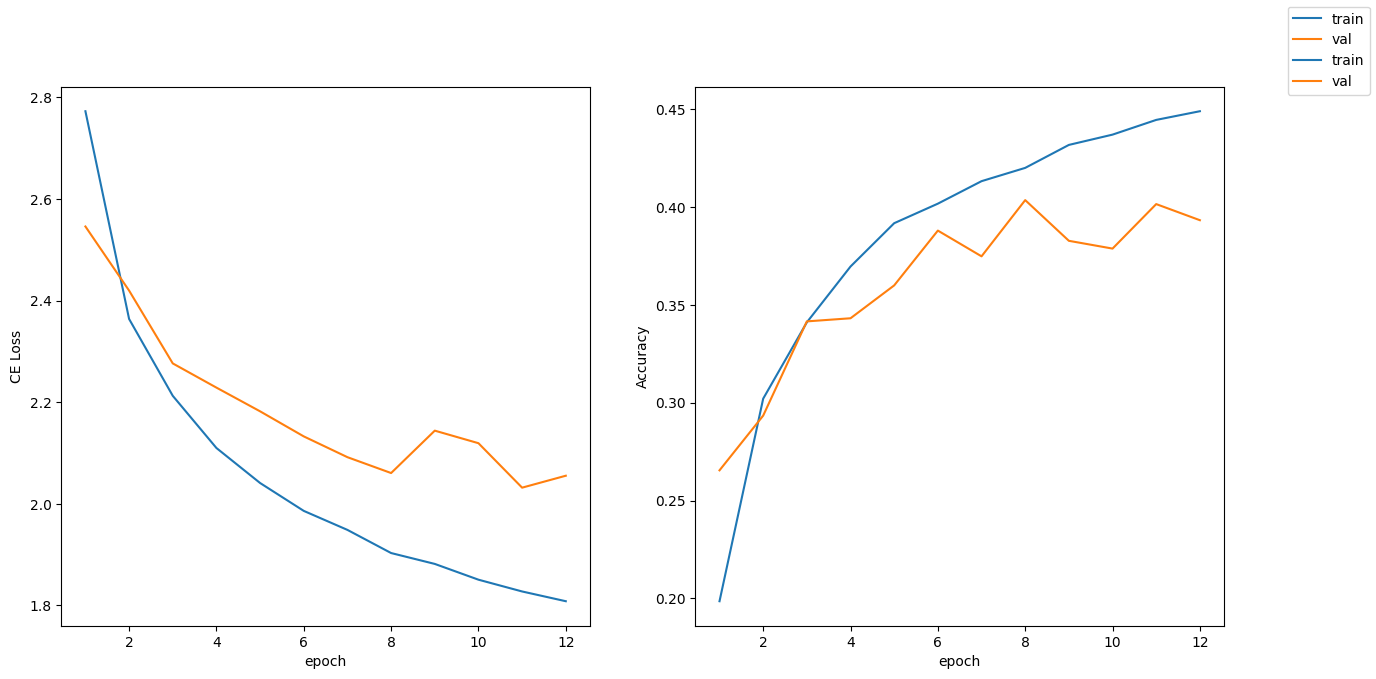

Epoch 12.
Train loss 1.8080585707900345. Train accuracy 0.4488865239640234.
Test loss 2.055092995817011. Test accuracy 0.39320720436312384


In [ ]:
train(model_upd, opt, epochs=14, batch_size=128)

### Prediction part

Prepare result file and send it to Yandex.Contest

In [ ]:
result = []
for idx, ytid in enumerate(testset._ytids):
    feats, _ = testset[idx]
    predict = torch.argmax(model_upd.forward(feats.reshape(1, FEATS, -1).to(DEVICE)), dim=1).item()
    result.append((ytid, trainset._idx_to_label[predict]))
pd.DataFrame(result, columns=['YTID', 'label']).to_csv('result.tsv', sep='\t', index=False)